## AB Tests

### 1. Оценка результатов AB теста

В данном задании вам требуется оценить результаты AB теста. Даны результаты на контрольной и тестовой группе после проведения AB теста.
Помимо показателей целевой переменной, вам даны также несколько фичей, которые являются характеристиками объектов. Даны целевые показатели (y) и принадлежность к целевой группе (W).

</u>Задача:</u>
1. Проверьте подходящую для данных гипотезу о равенстве средних в выборках
2. Каков treatment effect нашего воздействия? (ATE) 
3. Примените известные вам методы оценки ATE с учетом особенностей данных.
4. Проанализируйте, сравните результаты применения различных методов.
5. В явном виде выпишите выводы.

</i>Примечание: предположения о рандомизированном эксперименте нуждаются в проверке - независимость treatment от объектов не гарантирована. Все предположения выписывайте явно.</i> 

Для данной задачи используется dataset:  dataset_part1_students.csv

In [11]:
import pandas as pd
import numpy as np
import scipy as st
import seaborn as sns
import matplotlib.pyplot as plt

import scipy
from scipy.stats import normaltest
from scipy.stats import ttest_ind

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report

from sklearn.linear_model import LinearRegression
from statsmodels.regression.linear_model import OLS

from sklearn.tree import DecisionTreeClassifier

In [12]:
data1 = pd.read_csv('data/dataset_part1_students.csv', sep = '\t')

In [4]:
# Разные объекты  - не связанные выборки y. 

In [13]:
# Выборка размера 20000 объектов, следовательно, нужно брать уровень значимости порядка 0.0001

def H_check(Sample1, Sample2, name):
    alpha = 0.0001
    
    stat, p = normaltest(Sample1[name])
    
    print('stat = ', stat, 'p = ', p)
    if (p>alpha):
        print('Accept norm')
    else: 
        print('Reject norm')
    
    stat, p = normaltest(Sample2[name])
    print('stat = ', stat, 'p = ', p)
    if (p>alpha):
        print('Accept norm')
    else: 
        print('Reject norm')
        # p-value > alpha можно также проверить F-тест (Фишер) о равенстве дисперсий, который чувствителен к не нормальности.
    Fst = np.var(Sample1[name])/np.var(Sample2[name])
    
    power1, power2 = len(Sample1[name])-1, len(Sample2[name])-1
    
    # T критерий чувствиетельнее, если истинные дисперсии выборок равны
    p = scipy.stats.f.cdf(Fst, power1, power2)
    print('stat = ', Fst, 'p = ', p)
    if (p>alpha):
        print('Accept var == var')
        equal_var=True
    else:
        print('Reject var == var')
        equal_var=False
    
    # Выборки из нормального распределения, можно использовать t-критерий, хотя он относительно устойчив к не нормальности.
    stat, p = ttest_ind(Sample1[name], Sample2[name], equal_var=equal_var)
    print('stat = ', stat, 'p = ', p)
    
    if (p>alpha):
        print('Accept mean == mean')
    else:
        print('Reject mean==mean')
# При таком альфа p-value < alpha, значит, нулевая гипотеза отклоняется, средние в выборках не равны. 

In [14]:
H_check(data1[data1['W'] == 1], data1[data1['W'] == 0], 'y')

stat =  1.340089439214199 p =  0.511685694891655
Accept norm
stat =  0.06178545963522806 p =  0.9695795744755934
Accept norm
stat =  1.0010068251589588 p =  0.5199244727869714
Accept var == var
stat =  9.332400850259313 p =  1.1400916649505329e-20
Reject mean==mean


In [ ]:
# Качество рандомизации бывает полезно проверить, построив классификатор, используя
# в качестве таргета принадлежность к целевой или контрольной группе.  

In [106]:
X = data1.drop(['W', 'y'], axis = 1).copy()
y = data1['W']

X_train, X_test, y_train, y_test = train_test_split(X, y)
clf = LogisticRegression(random_state=42).fit(X_train, y_train)
rfc = RandomForestClassifier(random_state=42).fit(X_train, y_train)

y_pred_clf = clf.predict(X_test)
y_pred_rfc = rfc.predict(X_test)

In [8]:

print(classification_report(y_test, y_pred_clf))
print(classification_report(y_test, y_pred_rfc))
# Это проверка рандомизации - попытка классифицировать по W таргету. Ну так не очень.

              precision    recall  f1-score   support

         0.0       0.74      0.72      0.73      2385
         1.0       0.75      0.77      0.76      2615

    accuracy                           0.75      5000
   macro avg       0.75      0.75      0.75      5000
weighted avg       0.75      0.75      0.75      5000

              precision    recall  f1-score   support

         0.0       0.76      0.74      0.75      2385
         1.0       0.77      0.79      0.78      2615

    accuracy                           0.77      5000
   macro avg       0.77      0.77      0.77      5000
weighted avg       0.77      0.77      0.77      5000



In [ ]:
# Прежде чем расссматривать методы оценки TE необходимо сделать следующие предположения:
# 1. Uncounfoudedness
# Treatment assignment не зависит от результата эксперимента при условии контроля за X.
# Более слабое предположение, чем полная независимость.
# 2. Overlap
# Нет таких объектов, для которых невозможен treatment.

In [120]:
X = data1.drop(['y'], axis = 1).copy()
print(X.shape)
print(list(X))
y = data1['y']

slr = LinearRegression().fit(X, y)
print(slr.coef_)
print('tau = ', slr.coef_[0])
# Если я правильно поняла, то оценка третмент эффекта это тау - коэффициент перед W в модели линейной регрессии.

(20000, 11)
['W', 'X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_8', 'X_9', 'X_10']
[ 0.51338549 -0.2254694  -0.35712379 -0.09795053  0.93446704  0.42135781
  0.18572004  0.08389393 -0.10409036 -0.11725869  0.04936036]
tau =  0.513385488256559


In [52]:
X = data1.drop(['y'], axis = 1).copy()
y = data1['y']
model = OLS(y,X, random_seed = 2)
results = model.fit()
print('OLS ', [round(i, 3) for i in results.params])
print('tau = ', results.params[0])

OLS  [0.496, 0.053, -0.075, 0.183, 1.208, 0.703, 0.457, 0.357, 0.176, 0.155, 0.324]
tau =  0.49624729100326964


In [78]:
# Нахождение коэффициентов с помощью МНК
print(np.linalg.lstsq(X, y, rcond=None)[0])
print('tau = ', np.linalg.lstsq(X, y, rcond=None)[0][0])

[ 0.49624729  0.05265243 -0.07455112  0.18345008  1.20794482  0.7033204
  0.4571793   0.35714713  0.17598845  0.15509195  0.32402984]
tau =  0.496247291003268


In [ ]:
# Метод difference in differences здесь нельзя применить, так как неизвестно состояние до и после эксперимента.

In [137]:
# Стандартное отклонение ошибки равно
print(np.std(y)/np.sqrt(len(y)))
# Вывод: 
# Значит наблюдается влияние.

0.020756454653953545


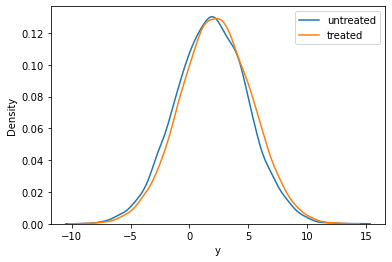

In [77]:
sns.kdeplot(data1.loc[lambda data1: data1['W'] == 0].y, label="untreated")
sns.kdeplot(data1.loc[lambda data1: data1['W'] == 1].y, label="treated")
plt.legend(loc='upper right')
plt.show()
# Но если смотреть не рисунок визуально разница не очень заметна.

### 2. Оценка результатов AB теста с показателями до начала эксперимента

Необходимо как и ранее оценить результаты AB теста, а именно ATE. Вы располагаете результатами до и после проведения теста (y_0 и y_1), а также вам дан treatment assignment (W). 

Необходимо: 
1. Проверить все требуемые гипотезы
2. Оценить ATE подходящим для этого случая методом (примените несколько методов)
3. Сравнить и проанализировать результаты оценок
4. Явно выписать выводы.

Как и прежде, все предположения должны быть указаны. Визуализация результатов приветствуется.

dataset_part2_students.csv

In [15]:
data2 = pd.read_csv('data/dataset_part2_students.csv', sep = '\t')

In [16]:
H_check(data2[data2['W'] == 1], data2[data2['W'] == 0], 'y_1')

stat =  5.547707153441431 p =  0.062420996569396064
Accept norm
stat =  0.04170043573953361 p =  0.9793656450567212
Accept norm
stat =  0.9859581106737935 p =  0.3085972162095497
Accept var == var
stat =  10.434076818229196 p =  2.3383131389683154e-25
Reject mean==mean


In [43]:
# Для данного случая подходит метод difference in defferences

In [63]:
# Оценка в difference in defferences равна tau = [E(y|T=1 W=1) - E(y|T=0 W=1)] -[ E(y| T=1 W=0 ) - E(y| T=0 W=0) ]
E1 = data2[data2['W'] == 1]['y_1'].mean()
E2 = data2[data2['W'] == 1]['y_0'].mean()
E3 = data2[data2['W'] == 0]['y_1'].mean()
E4 = data2[data2['W'] == 0]['y_0'].mean()
tau = (E1-E2)-(E3-E4)
print(tau)

0.5549047702971193


In [131]:
# Метод CUPED позволяет увеличить мощность оценки ATE. 
# Эксперимент не имеет достаточной мощности, если эксперимент слишком мал по сравнению с дисперсией.
# Если у выборки слишком большая дисперсия, то можно уменьшить ее таким образом.
y_1 = data2['y_1']
y_0 = data2['y_0']

cov_y = np.cov(y_0, y_1)[0][1]
theta = cov_y/np.std(y_0)
Tau_cuped = y_1 - (y_0 - y_0.mean())*theta

In [132]:
print(np.var(y_0))
print(np.var(Tau_cuped))

5.254644132737967
4.308304098016297


In [134]:
print(np.var(y_1))
print(np.var(Tau_cuped))

4.306339749101802
4.308304098016297


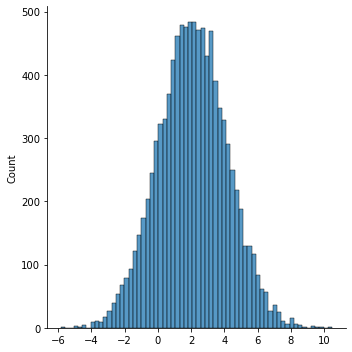

In [128]:
sns.displot(Tau_cuped)
# Мне не очень понятно, что с этим дальше нужно делать.

In [125]:
# Метод ANCOVA. 
X = data2.drop(['y_1'], axis = 1).copy()
y = data2['y_1']

model = OLS(y,X, random_seed = 2)
results = model.fit()
print('OLS ', [round(i, 3) for i in results.params])
print('tau = ', results.params[1])

OLS  [0.006, 0.533, -0.021, -0.054, 0.103, 1.201, 0.858, 0.302, 0.427, 0.344, 0.193, 0.21]
tau =  0.5331856104560021


In [136]:
# Стандартное отклонение ошибки равно
print(np.std(y)/np.sqrt(len(y)))
# Вывод: 
# Значит наблюдается значительное влияние.
# Получается метод достаточно эффективный (?).

0.020756454653953545


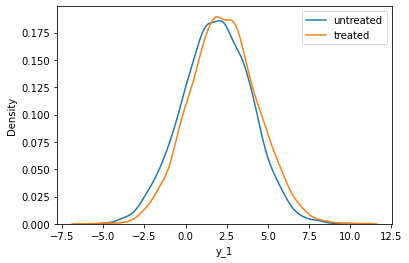

In [75]:
sns.kdeplot(data2.loc[lambda data2: data2['W'] == 0]['y_1'], label='untreated')
sns.kdeplot(data2.loc[lambda data2: data2['W'] == 1]['y_1'], label='treated')
plt.legend(loc='upper right')
plt.show()
# По рисунку, мне кажется, наоборот не особо заметна разница.

### 3. Построение uplift модели по результатам AB теста.

Вам даны результаты AB теста для модели конверсии клиента в продукте (conversion). Конверсия может принимать значения 1 или 0, что значит - клиент подключил услугу, либо не подключил соответственно.

Задача:
1. Оцените ATE по данным.
2. Оцените CATE для каждого наблюдения.
3. Проставьте рекомендации к воздействию на каждый объект.
4. Какая ожидаемая конверсия при оптимальном воздействии?
5. Все выводы, предпосылки и методы представляйте в явном виде в ноутбуке.

Визуализация результатов также будет приветствоваться.

dataset_part3_students.csv

In [7]:
data3 = pd.read_csv('data/dataset_part3_students.csv', sep = '\t')

In [9]:
data3['treatment'] = data3['treatment'].replace('control', 0)
data3['treatment'] = data3['treatment'].replace('treatment', 1)

In [6]:
H_check(data3[data3['treatment'] == 1], data3[data3['treatment'] == 0], 'conversion')

stat =  24517.551542482404 p =  0.0
Reject norm
stat =  41807.57284205178 p =  0.0
Reject norm
stat =  1.3790453381656178 p =  0.9999999999999999
Accept var == var
stat =  36.82180952095731 p =  8.171930853918917e-296
Reject mean==mean


In [64]:
X = data3.drop(['conversion'], axis = 1).copy()
y = data3['conversion']
model = OLS(y,X, random_seed = 2)
results = model.fit()
#print('OLS ', [round(i, 3) for i in results.params])
print('ate = ', results.params[0])
print('st ', np.std(y)/np.sqrt(len(y)))

ate =  0.1389989187126739
st  0.0008048163945118165


In [62]:
# Простейшая оценка
cate = data3[data3['treatment']==1]['conversion'].mean() - data3[data3['treatment']==0]['conversion'].mean()
y = data3['conversion']
print('cate ', cate)
print('st ', np.std(y)/np.sqrt(len(y)))
# Я совсем не поняла эту часть. Каким образом нужно искать CATE к каждому наблюдению.

cate  0.05907
st  0.0008048163945118165


In [69]:
# Double-Sample Trees
# Выберем слуяайно s наблюдений и разделим их на равные части I и J
s=200
Sample = data3.sample(n = s)
PartI = Sample[:(s//2)].copy()
PartJ = Sample[(s//2):].copy()
print('cate ', DS_Tree_cate(PartJ, PartI))

cate  0.09742351046698874


In [66]:
# Double-Sample Trees
def DS_Tree_cate(PartJ, PartI):
    
    X_train = PartJ.drop(['conversion'], axis = 1).copy()
    y_train = PartJ['conversion']
    X_test = PartI.drop(['conversion'], axis = 1).copy()
    y_test = PartI['conversion']
    k = int(len(y_train)/100)
    model = DecisionTreeClassifier(min_samples_leaf = k, random_state=2)
    results = model.fit(X_train, y_train)
    y_pred = results.predict(X_test)
    X_test['y'] = y_pred
    cate = X_test[X_test['treatment']==1]['y'].mean() - X_test[X_test['treatment']==0]['y'].mean()
    return cate

In [75]:
B = 1000
s = 1000
cate_s = 0
for i in range(B):
    Sample = data3.sample(n = s)
    PartI = Sample[:(s//2)].copy()
    PartJ = Sample[(s//2):].copy()
    
    cate_s+=DS_Tree_cate(PartJ, PartI)
print('cate ', cate_s/B)
print('st ', np.std(y)/np.sqrt(len(y)))
# Я совсем не поняла эту часть. Каким образом нужно искать CATE к каждому наблюдению.

cate  0.04356227697218563
st  0.0008048163945118165


EconML

In [18]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor

from econml.metalearners import TLearner, SLearner, XLearner, DomainAdaptationLearner

In [13]:
data3 = pd.read_csv('data/dataset_part3_students.csv', sep = '\t')

In [21]:
data3['treatment'] = data3['treatment'].replace('control', 0)
data3['treatment'] = data3['treatment'].replace('treatment', 1)

In [22]:
T = data3['treatment']
Y = data3['conversion']
X = data3.drop(['conversion', 'treatment'], axis = 1).copy()
# Instantiate T learner
n = len(X)
models = GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100))
T_learner = TLearner(models)
# Train T_learner
T_learner.fit(Y, T, X=X)
# Estimate treatment effects on test data
T_te = T_learner.effect(X)

In [27]:
T_te
# Получается, это оценка CATE для каждого наблюдения

array([ 0.0025654 , -0.02525319,  0.00706243, ..., -0.03827341,
       -0.0554676 , -0.06549299])

In [32]:
data3['CATE'] = T_te

In [34]:
st = np.std(Y)/np.sqrt(len(Y))

In [43]:
# Получается это объекты, эффект воздействия на которые меньше стандартного отклонения
# То есть на них не наблюдалось эффекта воздействия.
len(data3[(abs(data3['CATE'])<st) & (data3['treatment'] == 1)])

1106

In [44]:
# А на эти значит наблюдалось
len(data3[(abs(data3['CATE'])>st) & (data3['treatment'] == 1)])

98894

In [46]:
#data3['treatment'].sum()

In [47]:
#len(data3['treatment'])

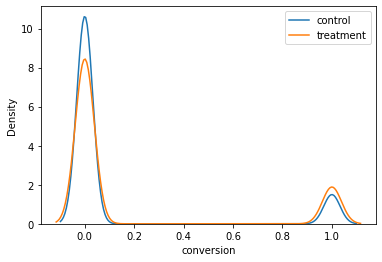

In [10]:
sns.kdeplot(data3.loc[lambda data3: data3['treatment'] == 0]['conversion'], label='control')
sns.kdeplot(data3.loc[lambda data3: data3['treatment'] == 1]['conversion'], label='treatment')
plt.legend(loc='upper right')
plt.show()